# Notebook 9 - Photo Groundstates in the presence of anharmonicities
-------------
We analyze the coupling of phononic (or equivalently a vibronic) excitation with infra-red (IR) activity to a single cavity photon mode. Specifically we want to investigate the effect of the cavity on the groundstate of a phonon whose potential energy landscape is described by a (quartic) double well potential. 

The Hamiltonian for such a system is

$$
\hat{H} = \hbar\omega_{\rm c} \left(\hat{a}^{\dagger}\hat{a} + \frac{1}{2}\right) + \frac{1}{2 M}\left[-\mathrm{i}\hbar \partial_x - A_0 Z_{\rm f}\left(\hat{a}^{\dagger}+\hat{a}\right)\right]^2 + V(x),
$$

where $\omega_{\rm c}$ is the frequency of the cavity mode, $\hat{a}^{\dagger}$ and $\hat{a}$ are the corresponding creation and annihilation operators, $\hat{A}=A_0(\hat{a}^{\dagger}+\hat{a})$ is the cavity vector potential,  $M$ the effective mass of the lattice vibration (sum of the masses of the atoms in the unit cell), $Z_{\rm{f}}$ the Born effective charge of the phonon mode and $V(x) = k_2 x^2 + k_4 x^4$ the confining, anharmonic, phonon potential.

## Q. 9.1 
---
Can you build the Hamiltonian for the phonon only and diagonalize it (you can use the function below)? Please plot the potential, plot the square of the first few eigenvectors and print the corresponding eigenvalues.

Make sure that you choose the parameters of the double well such that you get no node in the groundstate and the first excited state is separate in energy.

As a suggestion, use the following parameters M = 100, k2 = -0.1, k4 = 0.05, L=20, all in atomic units.

<details>
<summary>Hint</summary>

Use the representation of the second derivative operator of notebook 2.

</details>

In [14]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as sp_linalg

def diagonalize_H(H_pol, n_eig=10, sparse=False):
    if not sparse:
        ev_N, es_MN = np.linalg.eigh(H_pol)
    else:
        H_sparse = sp.csr_matrix(H_pol)
        ev_N, es_MN = sp_linalg.eigsh(H_sparse, k=n_eig, which='SM', tol=1e-7)

    #sort_N = np.argsort(ev_N)
    #ev_N = ev_N[sort_N]
    #es_MN = es_MN[:, sort_N]

    return np.array(ev_N), np.array(es_MN)

## A. 9.1
---

The first four eigenvalues are:
[-0.02341769 -0.01973676  0.01621483  0.04232194]


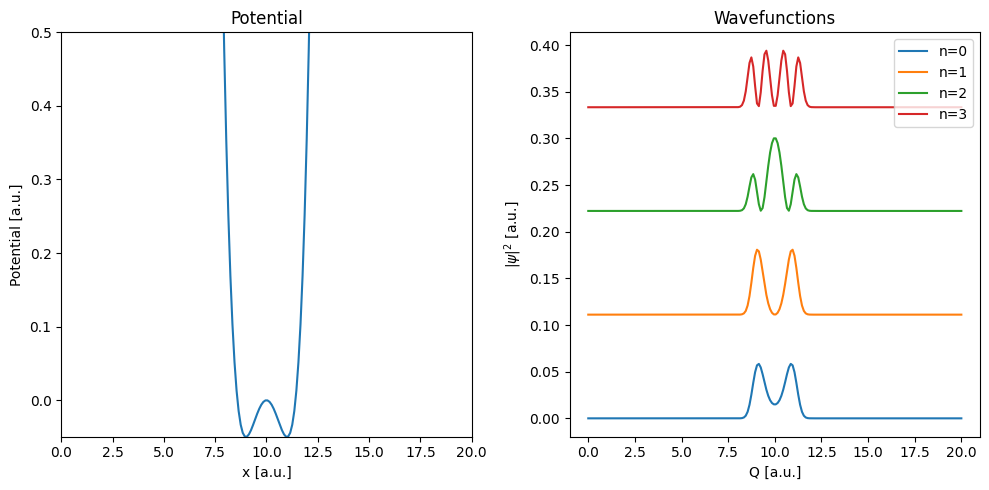

In [15]:
M = 100.   # Mass of the phonon
k2 = -0.1   # coefficient of the quadratic term
k4 = 0.05   # coefficient of the quartic term
npn_grid = 200   # number of grid points for the phonon
L = 20.           # box size for the phonon

# Setting up the phonon space
x_pn = np.linspace(0, L, npn_grid)
dx_pn = x_pn[1]-x_pn[0]

# Setting up Hamiltonian
#-----------------------
def build_H_pn(dx_pn, npn_grid, x_eq, x_pn):
    # dx_pn: grid spacing
    # npn_grid: number of grid points
    # x_eq: equilibrium position
    # x_pn: grid points

    nab2 = 1. / dx_pn**2 * (2*np.eye(npn_grid) - np.eye(npn_grid, k=1) - np.eye(npn_grid, k=-1))
    nab2[0, -1] = nab2[-1, 0] = -1
    K = 1./ 2. / M * nab2
    V = k2*np.diag((x_pn-x_eq)**2) + k4*np.diag((x_pn-x_eq)**4)
    return K, V, K+V

K, V, H_pn = build_H_pn(dx_pn=dx_pn, npn_grid=npn_grid, x_eq=L/2., x_pn=x_pn)

# Plotting Pot
plt.figure(figsize=(10, 5))
plt.subplot(121)  # 1 row, 2 columns, 1st subplot
plt.plot(x_pn, np.diag(V))
plt.xlim(0, L)
plt.ylim(np.min(V), 0.5)
plt.xlabel('x [a.u.]')
plt.ylabel('Potential [a.u.]')
plt.title('Potential')

# Plotting WFS
plt.subplot(122)  # 1 row, 2 columns, 2nd subplot
ev_N, es_MN = diagonalize_H(H_pn)

print('The first four eigenvalues are:')
print(ev_N[:4])

for n in range(0, 4, 1):
    n_x = np.abs(es_MN[:, n])**2 / np.sum(np.abs(es_MN[:, n])**2)
    plt.plot(x_pn, n_x + n/9., label='n=%s' % n)
plt.xlabel(r'Q [a.u.]')
plt.ylabel(r'$|\psi|^2$ [a.u.]')
plt.title('Wavefunctions')
plt.legend(loc=1)

plt.tight_layout()
plt.show()

## Q. 9.2
---
Now that we have the Hamiltonian for the phonon we can couple it to the photonic mode of the cavity. Let's use python to diagonalize the problem numerically again in a tensor product basis. However this time let's use a grid representation for the phononic mode so that we can more easily represent the anharmonic potential. That is we use a tensor-product basis

$$
\{|x\rangle\}\otimes\{|n\rangle\}_{n \in \mathcal{I}}
$$

with $\mathcal{I}= \{0, \dots , n_{ph}\}$. The code to build the polaritonic Hamiltonian from <font color='blue'>Notebook 7</font> is repeated below. You now need the `H_mat` that you built in the question above and to construct the matrix of the momentum operator `p_mat`. As a suggestion, use a Born-effective charge Z=12.

Once you have built and diagonalized the polaritonic Hamiltonian look at the phononic density in the groundstate and first excited states. Are they localized?

Analyze the results for different photon mode strenghts and for a frequency at least 5x higher than the first phononic resonance. 

<details>
<summary>Hint (a)</summary>
To build the momentum matrix, write the phononic momentum in terms of a symmetrized finite-difference first derivative
</details>

<details>
<summary>Hint (b)</summary>
Reflect on how to represent the phononic density operator in the mixed basis before plotting the density. You should end up with a trace over photonic states.
</details>

In [16]:
# Build polariton Hamiltonian from notebook 7
def build_Hpol(H_mat, wc, nph, p_mat, A_0):
    # H_mat: Hamiltonian of the matter
    # wc: frequency of the cavity
    # nph: number of photon states
    # p_mat: momentum matrix in the matter space
    # A_0: cavity mode strength

    # ---------------------
    # Light-Matter Diagonal
    # ---------------------
    e_tol = 1e-9
    H_mat_ph = np.kron(np.eye(nph), H_mat)

    H_ph_t = (np.diag(np.arange(0., nph*wc-e_tol, wc) + 0.5*wc) +
            1./2. * np.diag(2.*np.arange(0., nph*A_0**2-e_tol, A_0**2) + A_0**2))
    H_ph = np.kron(H_ph_t, np.identity(H_mat.shape[0]))

    # ---------
    # A^2 term
    # ---------
    n_quad = (np.sqrt(np.arange(0, nph-2, 1) + 1) * np.sqrt(np.arange(0, nph-2, 1) + 2))
    M_quad = np.diag(n_quad, k=2)

    H_A2 = 0.5 * np.kron(M_quad, np.eye(H_mat.shape[0]))
    H_A2 += np.transpose(H_A2).conj()

    # ----------
    # P.A term
    # ----------
    n_sqrt = np.sqrt(np.arange(0, nph-1, 1) + 1)
    M_sqrt = np.diag(n_sqrt, k=1)

    PAtot = np.kron(M_sqrt, p_mat)
    PAtot += PAtot.T.conj()

    # -----------------
    # Full Hamiltonian
    # -----------------
    H_pol = H_mat_ph + H_ph + A_0 * PAtot + A_0**2 * H_A2
    return H_pol

## A. 9.2
---

In [17]:
# Build the momentum matrix
Z = 12.
P_mat = -1.j * Z / dx_pn / M * (np.eye(npn_grid, k=1) - 1. * np.eye(npn_grid, k=-1))/2.
nph = 3

# Plotting with sliders
from ipywidgets import interact, FloatSlider
# Define function to update and plot
def plot_density(wc=0.1, A_0=0.1):
    H_pol = build_Hpol(H_mat=H_pn, wc=wc, nph=nph, p_mat=P_mat, A_0=A_0)
    ev, es = diagonalize_H(H_pol)

    es0 = es[:, 0].reshape((nph, npn_grid))
    es1 = es[:, 1].reshape((nph, npn_grid))

    es0_sum = np.zeros_like(es0[0], dtype=float)
    es1_sum = np.zeros_like(es1[0], dtype=float)
    for i in range(nph):
        es0_sum += np.abs(es0[i])**2
        es1_sum += np.abs(es1[i])**2

    plt.plot(x_pn, es0_sum, label='n=0')
    plt.plot(x_pn, es1_sum, label='n=1')

    plt.legend()
    plt.title(f'wc = {wc}, A_0 = {A_0}')
    plt.xlabel('Q_ph')
    plt.ylabel('Intensity')

    plt.show()

# Create sliders
wc_slider = FloatSlider(min=0.1, max=0.5, step=0.05, value=0.1, description='wc')
A_0_slider = FloatSlider(min=0.001, max=0.35, step=0.05, value=0.001, description='A_0')

# Interactive plot
interact(plot_density, wc=wc_slider, A_0=A_0_slider);

interactive(children=(FloatSlider(value=0.1, description='wc', max=0.5, min=0.1, step=0.05), FloatSlider(value…

## Addendum - Q. 9.3
---
Finally let us consider the effect of temperature on the groundstate density and the field fluctuations. To account for temperature we need to calculate expectation values by means of the finite temperature density matrix. The latter is defined as,

$$
\hat{\rho}^{\mathrm{pol}} =  \frac{\sum_I e^{-\beta E_I} \ket{\Psi^{\mathrm{pol}}_I}\bra{\Psi^{\mathrm{pol}}_I}}{\mathrm{Tr}\left[\sum_I e^{-\beta E_I} \ket{\Psi^{\mathrm{pol}}_I}\bra{\Psi^{\mathrm{pol}}_I}\right]}
$$

where the $\ket{\Psi^{\mathrm{pol}}_I}$ are the polaritonic eigenstates which you have calculated before and $\beta=1/k_{\mathrm{B}}T$. With the density matrix you can then calculate the thermal expectation value of an observable $\hat{O}$ as

$$
\langle \hat{O} \rangle_{\beta} = \mathrm{Tr}[\hat{\rho}^{\mathrm{pol}}\hat{O}]
$$

Using the formulas above, and the pre-made functions below, calculate the effect of temperature on the cavity-photon system with $A_0=0.3$ on the phonon density and the fluctuations of the field.

<details>
<summary>Hint (a)</summary>

As a suggested range of temperatures use $k_{\mathrm{B}} \in [0.01, 2]$.

</details>

<details>
<summary>Hint (b)</summary>

Remember from <font color='blue'>Notebook 1</font> that the field fluctations can be calculated as

$$
\delta E = \sqrt{\langle \hat{E^2} \rangle-\langle \hat{E}\rangle^2}
$$


</details>

In [18]:
# Use this function to calculate the trace

def get_trace(ev_I, es_IJ, temp, Op):
    # Trace with density matrix operator
    trace = np.sum(np.exp(-(ev_I - ev_I[0])/temp) * np.diag(np.dot(es_IJ.conj().T, np.dot(Op, es_IJ))))
    return np.real(trace)

# Use this function to build the density operator for each given x point in the phonon grid
def get_n_op_x(ix, nph, npn_grid):
    n_x_mat = np.zeros((npn_grid,npn_grid))
    n_x_mat[ix, ix] = 1
    n_op_x = np.kron(np.eye(nph), n_x_mat)
    return n_op_x

# Use this function to build the annihilation operator for the field fluctuations
def get_a_ops(nph, npn_grid):
    n_sqrt = np.sqrt(np.arange(0, nph, 1) + 1)
    np1, np2 = np.meshgrid(n_sqrt, n_sqrt)
    a = np.kron(np2 * np.eye(nph, k=1), np.eye(npn_grid))
    a_d = a.T.conj()
    return a, a_d


## A. 9.3
---

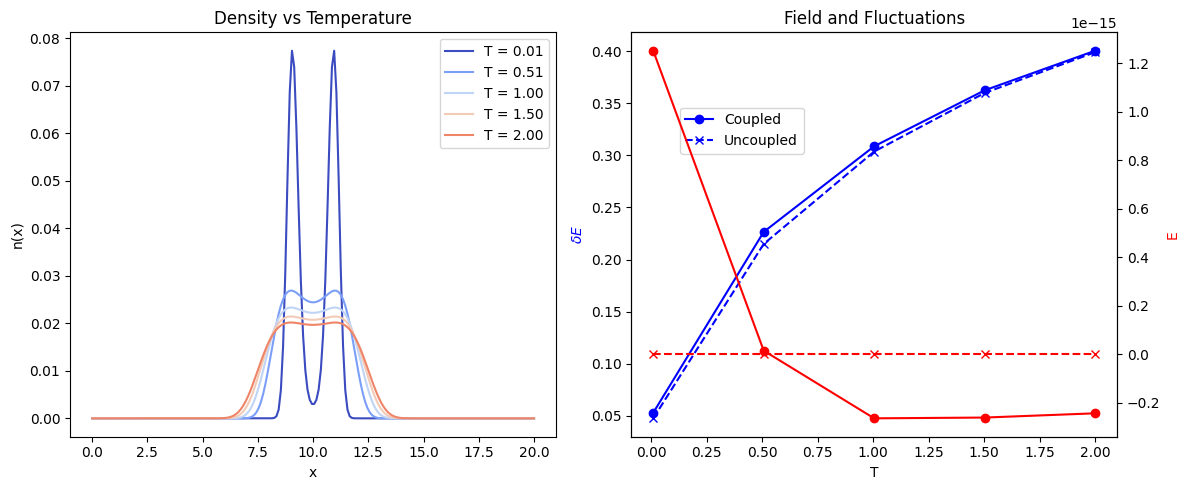

In [19]:
# Get the polaritons for the specific wc and A0
wc = 0.1
A_0 = 0.3
H_pol = build_Hpol(H_mat=H_pn, wc=wc, nph=nph, p_mat=P_mat, A_0=A_0)
ev, es = diagonalize_H(H_pol)

# Do the same for uncoupled problem
H_pol_un = build_Hpol(H_mat=H_pn, wc=wc, nph=nph, p_mat=0.*P_mat, A_0=A_0)
ev_un, es_un = diagonalize_H(H_pol_un)

T_list = np.linspace(0.01, 2, 5)   # List of temperatures

# Density calculation
n_xT = np.zeros((npn_grid, len(T_list)))
for ix in range(npn_grid):
    n_op_x = get_n_op_x(ix=ix, nph=nph, npn_grid=npn_grid)
    for iT, temp in enumerate(T_list):
        trace_x = get_trace(ev_I=ev, es_IJ=es, temp=temp, Op=n_op_x)
        n_xT[ix, iT] = trace_x

# Fluctuations calculation
a, a_d = get_a_ops(nph=nph, npn_grid=npn_grid)
E_op = 1.j * wc * A_0 * (a - a_d)
E2_op = np.dot(E_op.T.conj(), E_op)

# Coupled Problem
E_T = np.zeros(len(T_list))
Efl_T = np.zeros(len(T_list))
for iT, temp in enumerate(T_list):
    trace_E = get_trace(ev_I=ev, es_IJ=es, temp=temp, Op=E_op)
    trace_E2 = get_trace(ev_I=ev, es_IJ=es, temp=temp, Op=E2_op)
    E_T[iT] = trace_E
    Efl_T[iT] = np.sqrt(trace_E2 - trace_E**2)

# Uncouped Problem
E_un_T = np.zeros(len(T_list))
Efl_un_T = np.zeros(len(T_list))
for iT, temp in enumerate(T_list):
    trace_E = get_trace(ev_I=ev_un, es_IJ=es_un, temp=temp, Op=E_op)
    trace_E2 = get_trace(ev_I=ev_un, es_IJ=es_un, temp=temp, Op=E2_op)
    E_un_T[iT] = trace_E
    Efl_un_T[iT] = np.sqrt(trace_E2 - trace_E**2)


# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

cmap = matplotlib.colormaps['coolwarm']
for iT, temp in enumerate(T_list):
    color = cmap(iT / len(T_list))
    n_x = n_xT[:, iT] / np.sum(n_xT[:, iT])
    ax1.plot(x_pn, n_x + iT*0, color=color, label='T = %.2f' %temp)

ax1.set_xlabel('x')
ax1.set_ylabel('n(x)')
ax1.set_title('Density vs Temperature')
ax1.legend()

ax2.plot(T_list, Efl_T, '-ob', label='Coupled')
ax2.plot(T_list, Efl_un_T, '--xb', label='Uncoupled')
ax2.legend(loc=(0.1, 0.7))
ax2.set_xlabel('T')
ax2.set_ylabel(r'$\delta E$', c='b')
ax2.set_title('Field and Fluctuations')

ax3 = ax2.twinx()
ax3.plot(T_list, E_T, '-or')
ax3.plot(T_list, E_un_T, '--xr')
ax3.set_ylabel('E', c='r')


plt.tight_layout()
plt.show()
